# Computational Finance Research Notebook

## Load data and Packages

In [1]:
#Load libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import * 

In [2]:
#Load data in for in-sample
tickers = ["AMZN", "AAPL", "AMD"]
start = "2010-01-01"
end = "2019-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

[*********************100%***********************]  3 of 3 completed


In [3]:
#Load data in for out-of-sample
test_start = "2020-01-01"
test_end = "2024-12-31"

test_df_prices, test_df_changes = download_stock_price_data(tickers, test_start, test_end)

[*********************100%***********************]  3 of 3 completed


## Signal 1: Moving Average Crossover with MACD Indicator

#### 1.A) Define signal

In [4]:
def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig, _ = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig, _ = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig, macd_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

#### 1.B) Gridsearch best parameters for training set

For the parameter space we choose these parameters because in this literature ...

In [5]:
param_grid = {
    'short_ma': [10, 20, 30, 40, 50],
    'long_ma': [55, 75, 100, 125, 150, 175, 200],
    'short_macd': [12],
    'long_macd': [26],
    'signal_window_macd': [9]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal01, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(5))


=== Results for AMZN ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret  b&h cumret    sharpe  b&h sharpe
0        50      125          12         26                   9  4.342888   12.793054  0.769975    1.003531
1        50      150          12         26                   9  4.092156   12.793054  0.749180    1.003531
2        30      100          12         26                   9  3.708452   12.793054  0.731944    1.003531
3        40      100          12         26                   9  3.656298   12.793054  0.723167    1.003531
4        40      150          12         26                   9  3.574550   12.793054  0.718126    1.003531

=== Results for AAPL ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret  b&h cumret    sharpe  b&h sharpe
0        50      100          12         26                   9  5.793277    9.958798  0.997893    1.061273
1        40      100          12         26                   9  5.071083    9.95879

#### 1.C) Evaluate parameters on test set

We decide to evalute the best parameters on the 2020 to 2024 market regime because...

In [6]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal01(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)

In [7]:
df_test_results

,AMZN,AAPL,AMD
Strategy Cumulative Return,0.975708,2.409442,1.091090
BuyHold Cumulative Return,1.331916,2.464476,1.493686
Strategy Sharpe,0.602337,1.112735,0.554819
BuyHold Sharpe,0.652038,0.945263,0.611055
Sharpe Delta,-0.049701,0.167473,-0.056237
Strategy Max Drawdown,0.432993,0.313229,0.556586
BuyHold Max Drawdown,0.561453,0.314273,0.654499
Strategy Volatility,0.302818,0.248960,0.440801
BuyHold Volatility,0.359757,0.316891,0.524764


#### 1.D) Analysis and Graphs

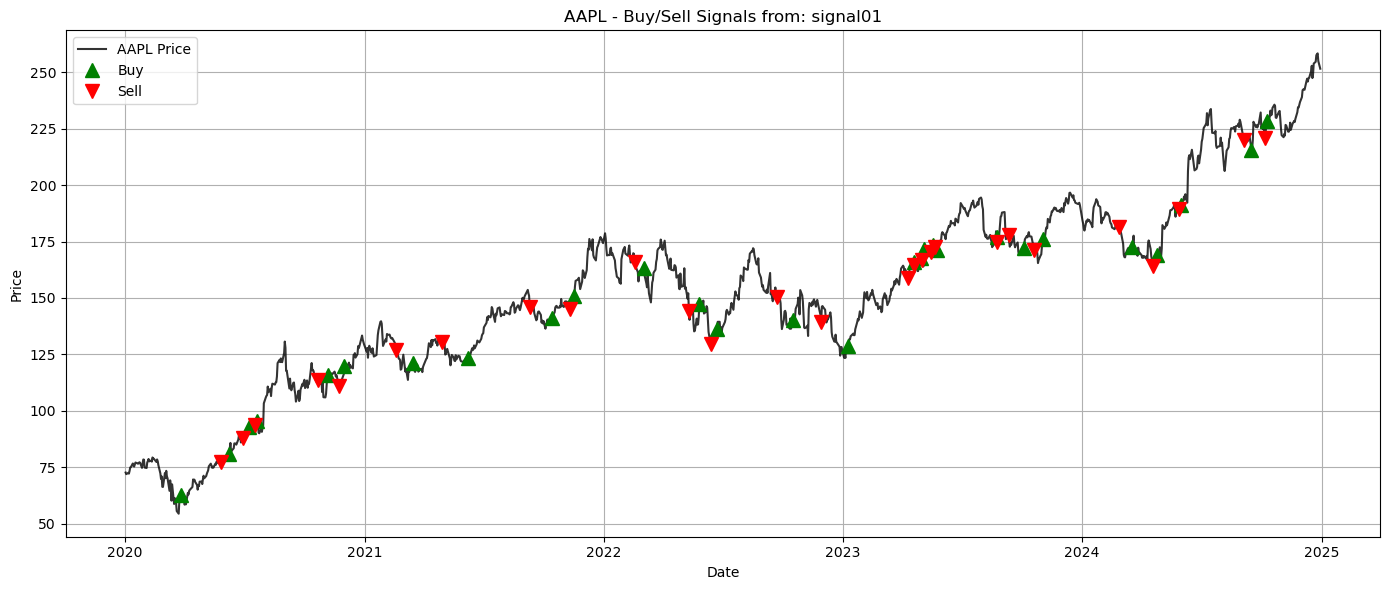

In [8]:
plot_buy_and_sell_signals(signal01, test_df_prices, 'AAPL', all_best_params['AAPL'])

## Signal 2: RSI with Bollinger Bands

#### 2.A) Define signal

In [ ]:
def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig, _ = signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig, _ = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig, bollinger_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

#### 2.B) Gridsearch best parameters for training set

In [10]:
param_grid = {
    'rsi_window_length': [10, 14],
    'lower_rsi_bound': [30, 40],
    'upper_rsi_bound': [60, 70],
    'bollinger_window_length': [10, 14],
    'bollinger_n_stds': [1, 1.5, 2]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal02, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for AMZN ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds      cumret  b&h cumret    sharpe  b&h sharpe
0                 14               30               60                       14               1.0  219.292933   12.793054  2.460451    1.003531
1                 10               30               60                       14               1.0  137.978618   12.793054  2.165185    1.003531
2                 14               30               70                       14               1.0  155.176684   12.793054  2.141930    1.003531

=== Results for AAPL ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds      cumret  b&h cumret    sharpe  b&h sharpe
0                 14               30               60                       14               1.0  125.581189    9.958798  2.618137    1.061273
1                 10               30               60                       14     

#### 2.C) Evaluate parameters on test set

In [11]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal02(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)

In [12]:
df_test_results

,AMZN,AAPL,AMD
Strategy Cumulative Return,5.713700,4.788446,58.357152
BuyHold Cumulative Return,1.331916,2.464476,1.493686
Strategy Sharpe,1.609317,1.527638,2.352043
BuyHold Sharpe,0.652038,0.945263,0.611055
Sharpe Delta,0.957279,0.582375,1.740988
Strategy Max Drawdown,0.225737,0.314273,0.386466
BuyHold Max Drawdown,0.561453,0.314273,0.654499
Strategy Volatility,0.258065,0.251349,0.379192
BuyHold Volatility,0.359757,0.316891,0.524764


#### 2.D) Analysis and interpretation

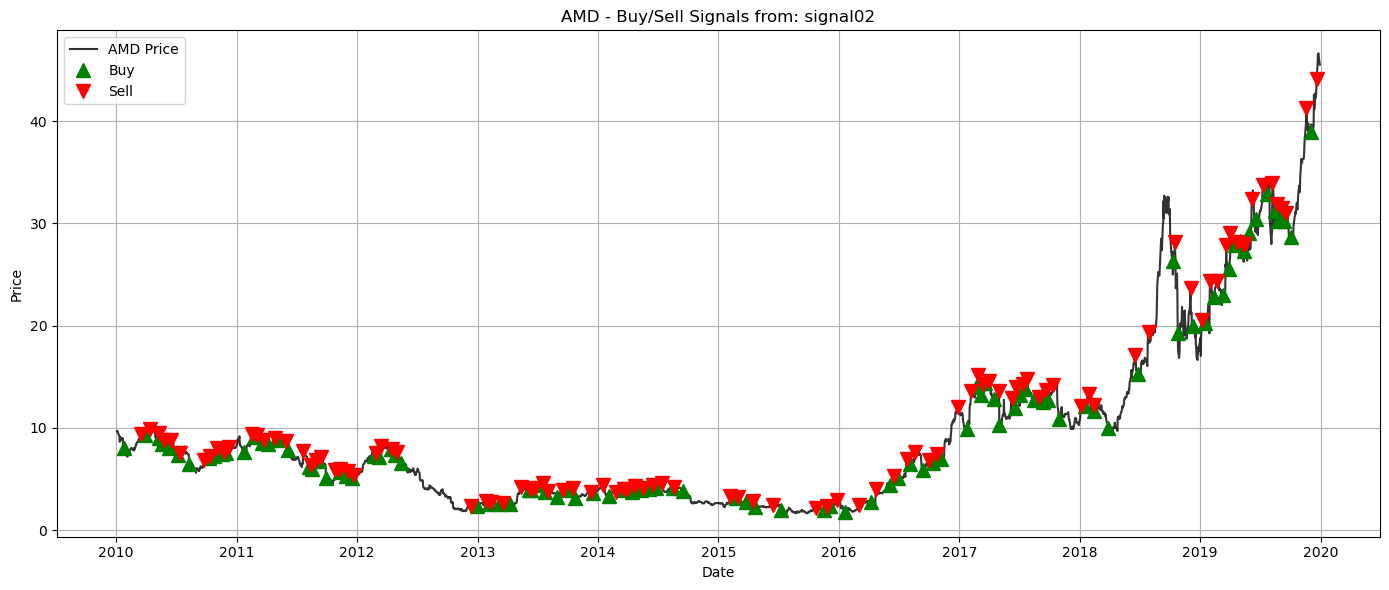

In [13]:
plot_buy_and_sell_signals(signal02, df_prices, 'AMD', all_best_params['AMD'])

## Signal 3: Donchian Channel with ADX

#### 3.A) Define signal

In [14]:
def signal03(prices, adx_window_length, adx_threshhold, donchian_window_length):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig, _ = donchian_signals(prices, donchian_window_length)
    donchian_sig = np.asarray(donchian_sig)

    #Custom tradig logic since adx only detects trends but not in which direction -> combine_two_subsignals() function doesn't work
    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and donchian_sig[i] == 1 and adx[i] > adx_threshhold:
            holding = 1
        elif holding == 1 and donchian_sig[i] == 0 and adx[i] > adx_threshhold:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

#### 3.B) Gridsearch best Parameters

In [15]:
param_grid = {
    'adx_window_length': [8, 10, 12, 14, 16, 18, 20],
    'adx_threshhold': [20, 22, 25, 26, 28, 30]
    'donchian_window_length': [8, 10, 12, 14, 16, 18, 20],
    
}

all_best_params = {}
for ticker in tickers:
    prices = test_df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal03, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for AMZN ===
   adx_window_length  donchian_window_length    cumret  b&h cumret    sharpe  b&h sharpe
0                 10                      14  2.544335    1.331916  0.963580    0.652038
1                 10                      20  2.520529    1.331916  0.952375    0.652038
2                 12                      14  2.559828    1.331916  0.925922    0.652038

=== Results for AAPL ===
   adx_window_length  donchian_window_length    cumret  b&h cumret    sharpe  b&h sharpe
0                  8                       8  3.378337    2.464476  1.250563    0.945263
1                 10                       8  2.689294    2.464476  1.108485    0.945263
2                  8                      10  2.734503    2.464476  1.102775    0.945263

=== Results for AMD ===
   adx_window_length  donchian_window_length    cumret  b&h cumret    sharpe  b&h sharpe
0                 10                      16  2.055940    1.493686  0.704563    0.611055
1                 10             

#### 3.C) Evaluate parameters on test set

In [16]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal03(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)

In [17]:
df_test_results

,AMZN,AAPL,AMD
Strategy Cumulative Return,2.544335,3.378337,2.055940
BuyHold Cumulative Return,1.331916,2.464476,1.493686
Strategy Sharpe,0.963580,1.250563,0.704563
BuyHold Sharpe,0.652038,0.945263,0.611055
Sharpe Delta,0.311543,0.305300,0.093508
Strategy Max Drawdown,0.453800,0.233726,0.515196
BuyHold Max Drawdown,0.561453,0.314273,0.654499
Strategy Volatility,0.314652,0.265050,0.482935
BuyHold Volatility,0.359757,0.316891,0.524764


#### 3.D) Analyisis and interpretation

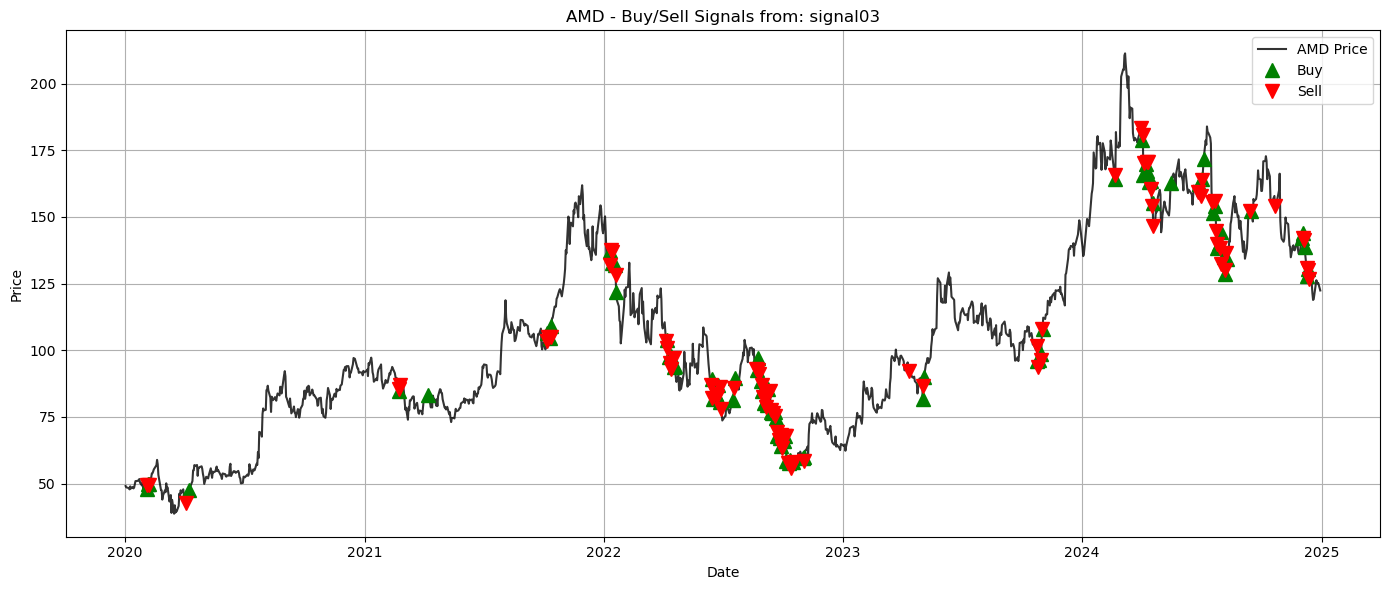

In [19]:
plot_buy_and_sell_signals(signal03, test_df_prices, 'AMD', all_best_params['AMD'])